# 텍스트분류
- RNN, CNN 이용해서 분류

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [ ]:
# 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
DATA_IN_PATH ='/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/'
DATA_OUT_PATH = '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/'

TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

RANDOM_SEED = 42
TEST_SPLIT = 0.2

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
# 파일로드
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## RNN 모델 

딥러닝을 활용해 분류하는 모델

문장 데이터를 입력해서 문장 흐름에서 패턴을 찾아 분류

이미 주어진 단어 특징벡터를 활용해 모델을 학습하지 않고 텍스트 정보를 입력해서 
문장에 대한 특정 정보를 추출


In [ ]:
# 모델 하이퍼 파라미터 정리
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

In [ ]:
# 모델 선언
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# Call Back Function 정의 Call Back Function 정의
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/rnn_classifier_en -- Folder already exists 



In [ ]:
# 모델 학습
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
1055/1055 [==============================] - 125s 115ms/step - loss: 0.5644 - accuracy: 0.6854 - val_loss: 0.4124 - val_accuracy: 0.8098

Epoch 00001: val_accuracy improved from -inf to 0.80980, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/rnn_classifier_en/weights.h5
Epoch 2/5
1055/1055 [==============================] - 122s 115ms/step - loss: 0.3901 - accuracy: 0.8255 - val_loss: 0.3986 - val_accuracy: 0.8210

Epoch 00002: val_accuracy improved from 0.80980 to 0.82100, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/rnn_classifier_en/weights.h5
Epoch 3/5
1055/1055 [==============================] - 123s 116ms/step - loss: 0.3566 - accuracy: 0.8448 - val_loss: 0.3962 - val_accuracy: 0.8231

Epoch 00003: val_accuracy improved from 0.82100 to 0.82307, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플ᄅ

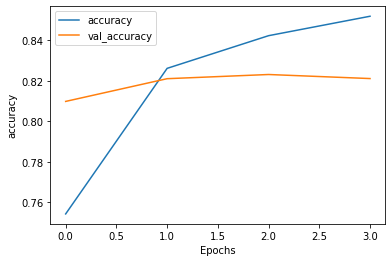

In [ ]:
plot_graphs(history, 'accuracy')

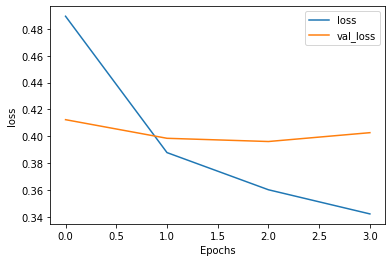

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
# 테스트 파일 읽기
DATA_OUT_PATH = DATA_OUT_PATH = '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [ ]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

answer = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'), allow_pickle=True)



In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(answer, predictions.round()))

0.84882


# CNN
합성곱 신경망은 전통적인 신경망 앞에 여러계층의 합성곱 계층을 쌓은 모델.

입력받은 이미지에 대한 가장 좋은 특징을 만들어 내도록 학습하고, 추출된 특징을 활용해 이미지를 분류한다.



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [ ]:

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
# 하이퍼 파라미터 지정

model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [ ]:
# 모델 구성
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/cnn_classifier_en -- Folder already exists 



In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/2
264/264 [==============================] - 37s 136ms/step - loss: 0.5345 - accuracy: 0.7133 - val_loss: 0.3948 - val_accuracy: 0.8190

Epoch 00001: val_accuracy improved from -inf to 0.81900, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/cnn_classifier_en/weights.h5
Epoch 2/2
264/264 [==============================] - 36s 136ms/step - loss: 0.3518 - accuracy: 0.8454 - val_loss: 0.3868 - val_accuracy: 0.8277

Epoch 00002: val_accuracy improved from 0.81900 to 0.82767, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/cnn_classifier_en/weights.h5


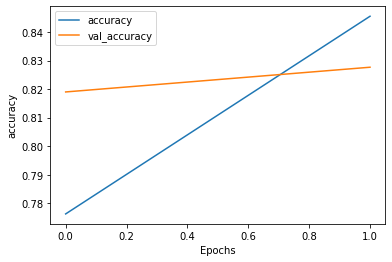

In [ ]:
plot_graphs(history, 'accuracy')

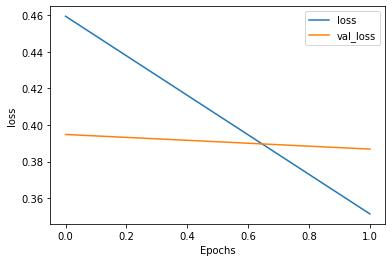

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(answer, predictions.round()))

0.8704
